In [1]:
import scvi
# import scib

import scanpy as sc
import pandas as pd
import numpy as np

Global seed set to 0


In [2]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [3]:
url = "https://figshare.com/ndownloader/files/24539828"
adata = sc.read("pancreas.h5ad", backup_url=url)
print(adata)

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'


In [4]:
adata.obs.tech.value_counts()

inDrop3       3605
smartseq2     2394
celseq2       2285
inDrop1       1937
inDrop2       1724
smarter       1492
inDrop4       1303
celseq        1004
fluidigmc1     638
Name: tech, dtype: int64

In [5]:
query = np.array([s in ["smartseq2", "celseq2"] for s in adata.obs.tech])

adata_ref = adata[~query].copy()
adata_query = adata[query].copy()

In [6]:
sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=2000,
    batch_key="tech",
    subset=True
)

adata_query = adata_query[:, adata_ref.var_names].copy()

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/

In [7]:
scvi.model.SCVI.setup_anndata(adata_ref, batch_key="tech", layer="counts")

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [8]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

# vae_ref = scvi.model.SCVI(
#     adata_ref,
#     **arches_params
# )
# vae_ref.train()

In [9]:
dir_path = "../../notebooks/pancreas_model/"
# vae_ref.save(dir_path, overwrite=True)

In [10]:
vae_ref = scvi.model.SCVI.load(dir_path, adata_ref)

INFO     File ../../notebooks/pancreas_model/model.pt already downloaded                     


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [11]:
vae_ref

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.2, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

In [12]:
vae_ref.summary_stats

attrdict({'n_cells': 11703, 'n_vars': 2000, 'n_batch': 7, 'n_labels': 1, 'n_extra_categorical_covs': 0, 'n_extra_continuous_covs': 0})

In [13]:
adata_ref.obsm["X_scVI"] = vae_ref.get_latent_representation(adata_ref)
sc.pp.neighbors(adata_ref, use_rep="X_scVI")
# sc.tl.leiden(adata_full)
sc.tl.umap(adata_ref)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


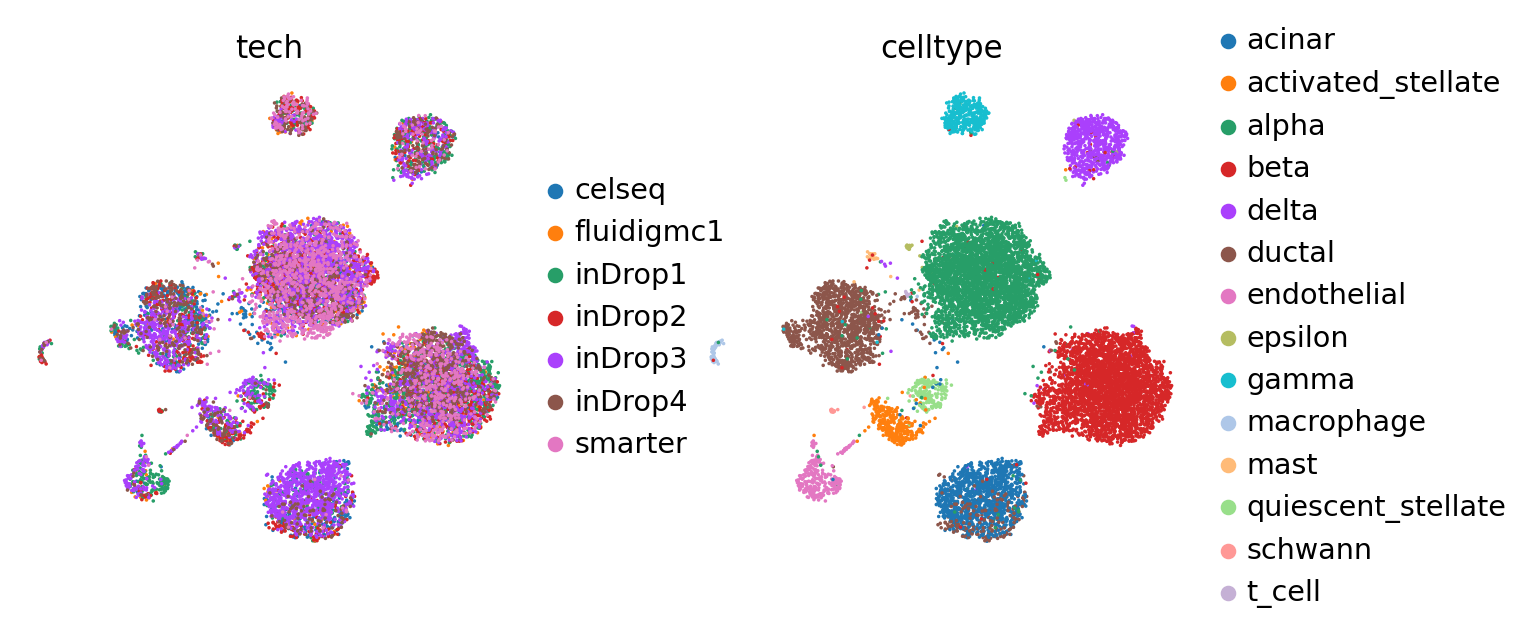

In [14]:
sc.pl.umap(
    adata_ref,
    color=["tech", "celltype"],
    frameon=False,
    ncols=2,
#     save = 'pancreas_scvi.png'
)

In [15]:
scvi.model.SCVI.setup_anndata(adata_query, batch_key="tech", layer="counts")

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [16]:
# vae_q = scvi.model.SCVI.load_query_data(
#     adata_query,
#     dir_path,
#     unfrozen = True
# )

In [17]:
# vae_q.train(max_epochs=500, plan_kwargs=dict(weight_decay=0.0))

In [18]:
# vae_q.save('pancreas_continue_unfrozen_longepochs')

In [19]:
vae_q = scvi.model.SCVI.load(
                    '../../notebooks/pancreas_continue_unfrozen_longepochs',
                     adata_query
)

INFO     File ../../notebooks/pancreas_continue_unfrozen_longepochs/model.pt already         
         downloaded                                                                          


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [20]:
adata_ = adata_ref.copy()
adata_.obs['tech_orig'] = adata_ref.obs.tech
# adata_.obs.tech = "celseq2"

In [21]:
adata_query.obs["source"] = "query"
adata_query.obs["tech_orig"] = adata_query.obs.tech

In [22]:
adata_full = adata_query.concatenate(adata_)
adata_full.obsm["X_scVI"] = vae_q.get_latent_representation(adata_full)
sc.pp.neighbors(adata_full, use_rep="X_scVI")
# sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


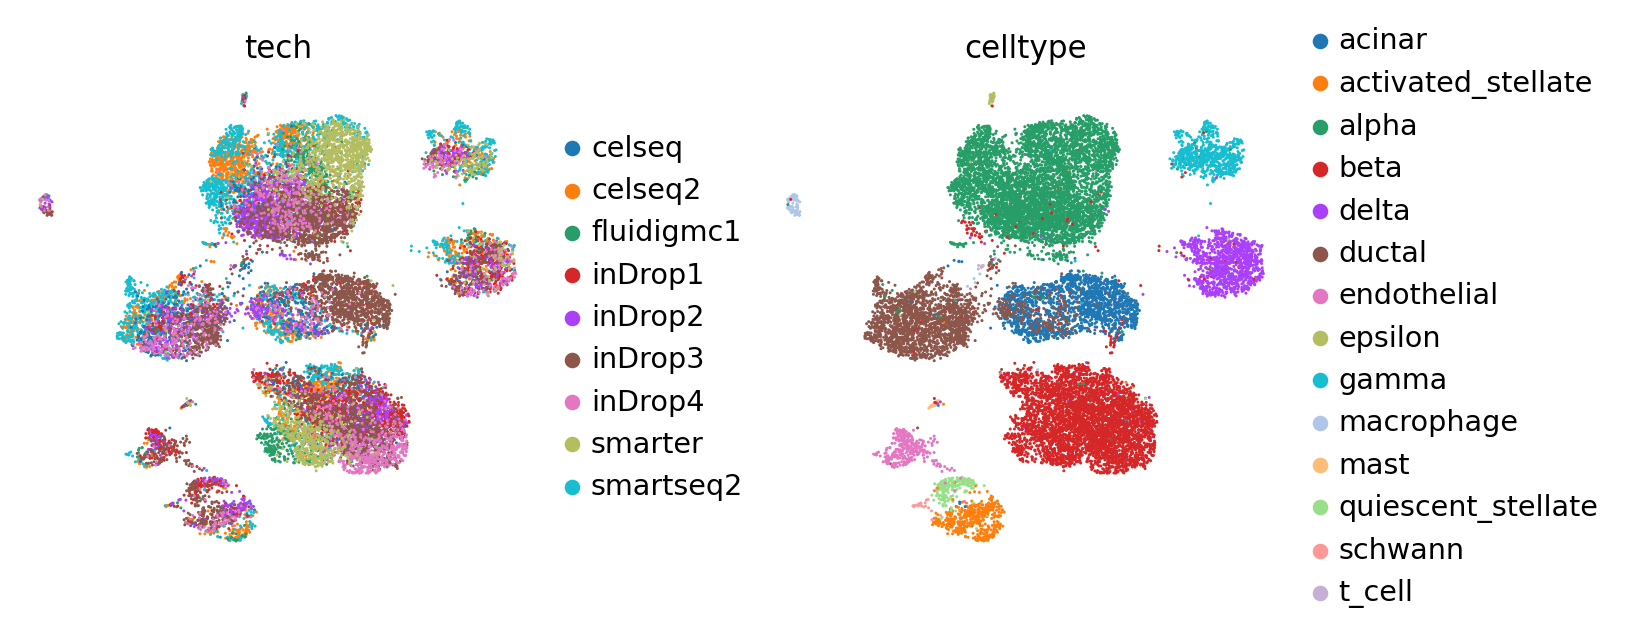

In [24]:
sc.pl.umap(
    adata_full,
    color=["tech", "celltype"],
    wspace = 0.3,
    frameon=False,
    ncols=2,
    save = '_pancreas_finetune.png'
)

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


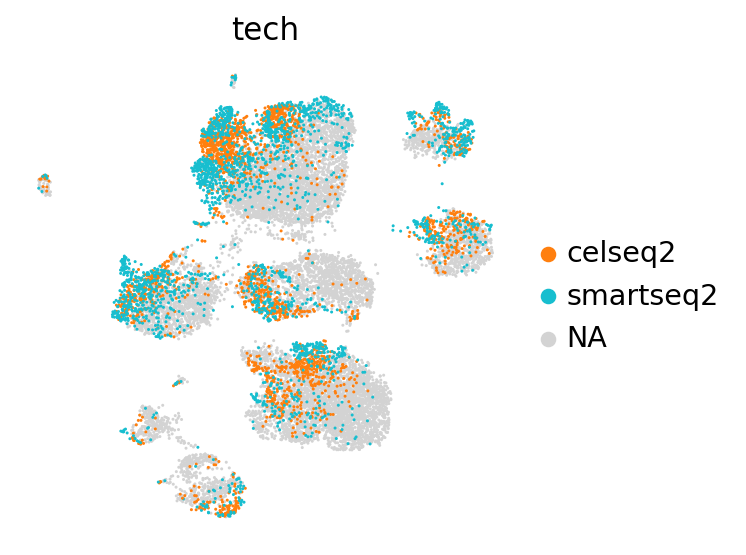

In [25]:
sc.pl.umap(
    adata_full,
    color=["tech"],
    groups = ['celseq2','smartseq2'],
    frameon=False,
    ncols=2,
)

In [26]:
techs = adata_full.obs.tech.cat.categories.tolist()
techs = [x for x in techs if x not in ['celseq2','smartseq2']]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


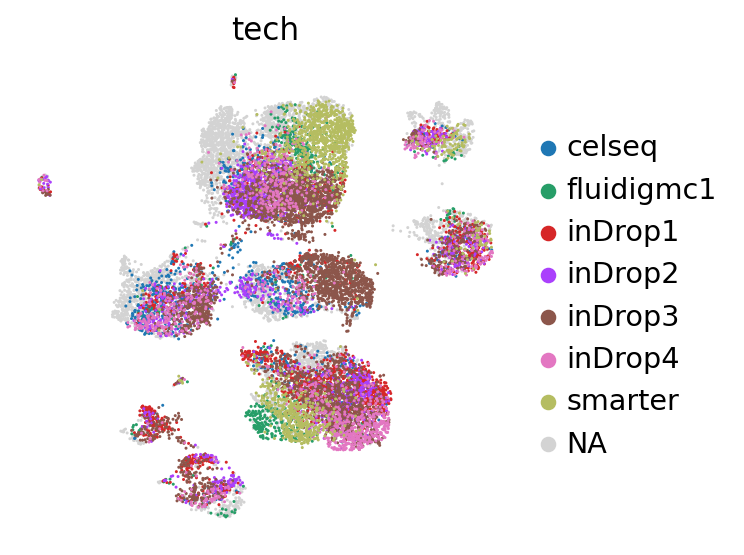

In [27]:
sc.pl.umap(
    adata_full,
    color=["tech"],
    groups = techs,
    frameon=False,
    ncols=2,
)

In [28]:
adata_full.write('../results/pancreas_finetune_latent.h5ad')